<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo"  />


<img src="https://keras.io/img/logo.png">


Estimated time needed: **60** minutes


<h2> Image Classification with Convolution Neural Network (CNN) using  Keras and Tensorflow</h2>
<h3>Project: Stop_or_Not_Stop</h3>
<h3>Training Run: Train_StopSignsMay_07_Keras</h3>


A Convolutional Neural Network is a type of neural network that is used to train models using images.


<ul>
    <li>Table of Content
        <ul>
            <li>Download Images and Annotations</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>

</ul>


***


## Load Important Libraries


In [1]:
#if you get an error in your environment please uncomment to install neccessary packages
# !pip install imutils
# !pip install skillsnetwork
# !pip install tensorflow==1.15

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import set_random_seed
import os
from os import path
from datetime import datetime
import shutil
import random
from skillsnetwork import cvstudio

ImportError: cannot import name 'set_random_seed' from 'tensorflow' (C:\Users\uyjoe\anaconda3\lib\site-packages\tensorflow\__init__.py)

## Download Your Images and Annotations


Now let's download the images from CV Studio.

If you have run this section before, you don't need to run it again. Feel free to jump to the <b>Build the Model</b> section.


In [2]:
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()

# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 194/194 [00:28<00:00,  6.87it/s]


In [3]:
# Get the annotations from CV Studio
annotations = cvstudioClient.get_annotations()
num_classes = len(annotations['labels'])

In [4]:
num_classes

2

In [5]:
# Move files into folders

def labeldir(label):
    return path.join(os.getcwd(), 'images', label)

for label in annotations['labels']:
    if not path.exists(labeldir(label)):
        os.mkdir(labeldir(label))

for key, value in annotations['annotations'].items():
    src = path.join(os.getcwd(), 'images', key)
    if path.exists(src):
        dest = (path.join(labeldir(value[0]['label']), key))
        shutil.move(src, dest)

## Build the Model

We start with a MobileNetV2 architecture as the backbone pretrained feature extractor. We then add a couple of dense layers and a softmax layer to perfom the classification. We freeze the MobileNetV2 backbone with weights trained on ImageNet dataset and only train the dense layers and softmax layer that we have added.


In [6]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 1
x=tf.keras.layers.Dense(256,activation='relu')(x) #dense layer 2
preds=tf.keras.layers.Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=base_model.input,outputs=preds)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


2022-05-07 21:13:59.046492: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-05-07 21:13:59.057256: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2494050000 Hz
2022-05-07 21:13:59.057873: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c103ea0ee0 executing computations on platform Host. Devices:
2022-05-07 21:13:59.057913: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-05-07 21:13:59.419376: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line fl

In [7]:
#Freeze layers from MobileNetV2 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

In [8]:
#Prepare the training dataset as a data generator object
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('images',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 194 images belonging to 2 classes.


In [9]:
# Build the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
______________________________________________________________________________________________

## Train the Model


In [10]:
start_datetime = datetime.now()

set_random_seed(2)
step_size_train=5
epochs=4
log_file = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/4
5/5 [==============================] - 15s 3s/step - loss: 1.6396 - acc: 0.5000
Epoch 2/4
5/5 [==============================] - 15s 3s/step - loss: 0.6746 - acc: 0.6400
Epoch 3/4
5/5 [==============================] - 14s 3s/step - loss: 0.5576 - acc: 0.7200
Epoch 4/4
5/5 [==============================] - 14s 3s/step - loss: 0.6150 - acc: 0.6400
Training Duration: 0:00:59.385156


## Model Performance


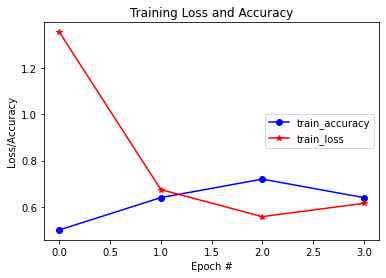

In [11]:
# Model accuracy and loss vs epoch
plt.plot(log_file.history['acc'], '-bo', label="train_accuracy")
plt.plot(log_file.history['loss'], '-r*', label="train_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

## Let's Report Our Results Back to CV Studio


In [13]:
parameters = {
    'epochs': epochs,
    'step_size_train': step_size_train,
    'class_indices': train_generator.class_indices
}
accuracy = {
    'accuracy': log_file.history['acc'],
    'loss': log_file.history['loss']
}
result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy=accuracy)

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


In [14]:
# Save the model to a file
model.save('my_model.h5')

In [16]:
parameters = {
    'epochs': epochs,
    'step_size_train': step_size_train,
    
}
# Now let's save the model back to CV Studio
result = cvstudioClient.uploadModel('my_model.h5', parameters)


File Uploaded


# Thanks for completing this notebook!
